In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# PyTorch CNN Tutorial
## CIFAR-10 Image Classification

CIFAR-10 데이터셋을 사용하여 이미지 분류 모델을 구축하고 학습시킵니다.

### 목차
1. Torch Tensor 기초
2. Autograd (자동 미분)
3. Torch nn 모듈
4. 모델 만들기
5. Optimizer와 Loss Function
6. 데이터 준비
7. 커스텀 데이터셋 클래스
8. DataLoader
9. Early Stopping
10. 학습 및 평가 함수
11. 모델 학습 실행
12. 테스트
13. Pretrained 모델 불러오기
14. 전이학습
15. 모델 저장 및 불러오기
16. 추론 예시


In [2]:
%matplotlib inline
# 필요한 라이브러리 import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import timm # Torch Image Models

import numpy as np
from tqdm import tqdm # 진행도바 그려주는 라이브러리
import matplotlib.pyplot as plt
from collections import defaultdict
import copy



C:\Users\elian\miniconda3\envs\pytorch_tutorial\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Torch <-> Keras
- Torch는 사용할 장비를 골라줘야 함
- Keras는 알아서 기본적으로 잡아줌(설정 가능)

In [3]:
torch.cuda.is_available() # NVIDIA GPU + 라이브러리 준비되어 있음 ? True 반환

False

In [4]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")

PyTorch version: 2.8.0+cpu
Using device: cpu


## 1. Torch Tensor 기초

PyTorch의 기본 데이터 구조인 Tensor에 대해 알아봅니다.


In [5]:
# Tensor 생성
tensor_a = torch.tensor([1, 2, 3, 4, 5])
tensor_b = torch.randn(3, 4) # 3x4 랜덤 텐서
tensor_c = torch.zeros(2, 3) # 2x3 영행렬
tensor_d = torch.ones(2, 3)  # 2x3 일행렬

print(f"tensor_a: {tensor_a}")
print(f"tensor_b: {tensor_b}")
print(f"tensor_b shape: {tensor_b.shape}")
print(f"tensor_c: {tensor_c}")

tensor_a: tensor([1, 2, 3, 4, 5])
tensor_b: tensor([[ 0.4131, -0.7487,  0.4842, -0.0501],
        [ 0.3175,  3.1729, -0.2004,  1.8540],
        [ 0.7949,  0.4435, -0.7110,  1.2810]])
tensor_b shape: torch.Size([3, 4])
tensor_c: tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [6]:
# Tensor 연산
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])

# 기본 연산
add_result = x + y
mul_result = x * y  # element-wise multiplication: 같은 자리끼리 연산. 크기 서로 안 맞으면 알아서 존재하는 자리끼리만 연산해줌
matmul_result = torch.matmul(x, y) # mat multiplication(행렬곱 → 수학 행렬곱과 같은 개념) # dot product

print(f"\n덧셈: {add_result}")
print(f"곱셈(element-wise): {mul_result}")
print(f"내적: {matmul_result}")


덧셈: tensor([5, 7, 9])
곱셈(element-wise): tensor([ 4, 10, 18])
내적: 32


In [7]:
arr_a = np.array([1, 2])
arr_b = np.array([3])

arr_a * arr_b # broadcasting 자동 발생

array([3, 6])

In [8]:
# 행렬곱
matrix_a = torch.randn(2, 3)
matrix_b = torch.randn(3, 4)

matrix_mul = torch.matmul(matrix_a, matrix_b)
print(f"\n행렬곱 결과 shape: {matrix_mul.shape}")


행렬곱 결과 shape: torch.Size([2, 4])


In [9]:
# Reshape 연산
original = torch.randn(2, 3, 4)
print(original)

tensor([[[-0.3041, -1.4186,  0.8773,  0.6661],
         [-1.7203,  0.8407,  0.5851, -1.2950],
         [ 0.0578,  1.3567,  0.4487,  1.1047]],

        [[ 0.2299, -0.5530,  0.8967, -1.6214],
         [ 1.0296,  0.9344, -0.1206,  0.4206],
         [ 0.1268, -2.0168,  0.7853, -0.0174]]])


In [10]:
# Reshape 연산
original = torch.randn(2, 3, 4)
reshaped = original.view(12, -1)  # view: reshape과 유사
print(f"\nOriginal shape: {original.shape}, Reshaped: {reshaped.shape}")



Original shape: torch.Size([2, 3, 4]), Reshaped: torch.Size([12, 2])


## 2. Autograd (자동 미분)

PyTorch의 자동 미분 시스템에 대해 알아봅니다.


In [11]:
# requires_grad=True로 gradient 추적
x = torch.tensor([2., 3.], requires_grad=True) # batch가 한번 돌때마다의 학습(계산) 과정 기록 설정
y = x ** 2 + 3 * x + 1 # 학습 결과로 가정

In [12]:
x

tensor([2., 3.], requires_grad=True)

In [13]:
y

tensor([11., 19.], grad_fn=<AddBackward0>)

In [14]:
# y를 x로 미분
y_sum = y.sum()  # requires_grad=True를 통해 계산된 값인 y 에 backward() 실행이 가능하다는 점을 설명하고자 별도 변수를 선언해 더한 값을 할당했을 뿐, 굳이 모든 y를 안 더해도 된다.
y_sum.backward() # 각 학습 결과 y의 모든 케이스를 총합 → 미분
# print(f"y_sum: {y_sum}")

print(f"x: {x}")
print(f"y: {y}") # grad_fn=<AddBackward0> → backward() 사용 가능함 표시됨
print(f"dy/dx: {x.grad}")  # 2*x + 3의 값 → x ** 2 + 3 * x + 1의 미분


x: tensor([2., 3.], requires_grad=True)
y: tensor([11., 19.], grad_fn=<AddBackward0>)
dy/dx: tensor([7., 9.])


In [15]:
# Gradient 초기화
x.grad.zero_()
print(f"Gradient 초기화 후: {x.grad}")

Gradient 초기화 후: tensor([0., 0.])


## 파이토치를 활용한 선형 회귀 연습
선형 회귀(Linear Regression)는 머신러닝과 통계 분야에서 널리 사용되는 기본적인 예측 기법 중 하나입니다. 선형 회귀의 주된 목적은 데이터 포인트 간의 선형 관계를 파악하는 것입니다. 즉, 주어진 독립 변수(X)를 기반으로 종속 변수(Y)의 값을 예측하는 것입니다.


### 데이터 준비
선형 회귀를 위한 학습 데이터를 준비합니다.

우리가 사용할 데이터는 x와 y 사이에 간단한 선형 관계, y=2x 라는 관계를 가진 데이터를 사용합니다.

In [16]:
x_train = torch.FloatTensor([[1], [2], [3]]) # 데이터
y_train = torch.FloatTensor([[2], [4], [6]]) # 라벨

In [17]:
print(x_train)
print(x_train.shape)

tensor([[1.],
        [2.],
        [3.]])
torch.Size([3, 1])


In [18]:
print(y_train)
print(y_train.shape)

tensor([[2.],
        [4.],
        [6.]])
torch.Size([3, 1])


### 가중치와 편향 초기화
선형 회귀의 목표는 주어진 데이터에 대해 가장 잘 맞는 직선을 찾는 것입니다. 이 직선은 y = Wx + b로 표현될 수 있으며, 여기서


**W는 가중치(weight)이고,**


**b는 편향(bias)입니다.**


데이터 학습을 시작하기 전에, 초기의
W와 b 값을 정해줄 필요가 있습니다. 일반적으로는 랜덤 값으로 시작하나, 이 예제에서는 간단히
W를 0으로 시작하겠습니다.

In [19]:
# 업데이트 가능 / 학습가능
W = torch.zeros(1, requires_grad=True) # 가중치(기울기)
W

tensor([0.], requires_grad=True)

In [20]:
b = torch.ones(1, requires_grad=True) # 편향(편차)
b

tensor([1.], requires_grad=True)

### 가설(hypothesis) 설정하기
선형 회귀의 핵심은 주어진 x값에 대한 예측값 y를 찾는것 입니다. 이 예측값을 구하기 위해 가설 이라는 함수를 정의합니다 여기서는 간단한 선형 가설을 사용합니다

In [21]:
# 순전파(Forward pass)
hypothesis = x_train * W + b # Prediction(모델의 예측값)
print(hypothesis)

tensor([[1.],
        [1.],
        [1.]], grad_fn=<AddBackward0>)


### 비용함수 및 최적화
우리의 목표는 주어진 데이터에 가장 잘 맞는 직선을 찾는 것입니다. 이를 위해 실제값과 예측값 사이의 차이를 계산하는 비용 함수를 정의하게 됩니다. 선형 회귀에서는 주로 평균 제곱 오차(Mean Squared Error, MSE)를 비용 함수로 사용합니다.

**평균 제곱 오차(Mean Squared Error)**

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n}(\text{예측값} - \text{실제값})^2$$

**최적화(optimization)**

선형 회귀의 학습 과정은 이 비용을 최소화하는 가중치 W와 편향 b를 찾는 것입니다. 이를 위해 경사 하강법(Gradient Descent)와 같은 최적화 알고리즘이 사용됩니다. 파이토치에서는 다양한 최적화 알고리즘을 제공하며, 여기서는 SGD(Stochastic Gradient Descent)를 사용하였습니다.

In [22]:
# 손실 계산
cost = torch.mean((hypothesis - y_train) ** 2) # MSE
print(f"예측값 - 실제값: {hypothesis - y_train}")
print(cost)

예측값 - 실제값: tensor([[-1.],
        [-3.],
        [-5.]], grad_fn=<SubBackward0>)
tensor(11.6667, grad_fn=<MeanBackward0>)


In [23]:
W, b

(tensor([0.], requires_grad=True), tensor([1.], requires_grad=True))

In [24]:
# 역전파

# optimizer 선언 # 최적화 알고리즘 
# Optimizer 역할 : 계산된 손실의 기울기(Gradient)를 기반으로 파라미터를 어떻게? 업데이트할지를 알려주는 로직
optimizer = torch.optim.SGD((W, b), lr=0.01) # lr = learning rate 변환의 범위
# gradient를 0으로 초기화
optimizer.zero_grad()
# 비용 함수를 미분하여 gradient 계산
cost.backward() # W, b에 Gradient가 저장됨
# W와 b를 업데이트
optimizer.step() # W.grad, b.grad 바탕으로 W, b가 경사하강법에 의해서 업데이트됨

In [25]:
W, b # 순전파부터 순서대로 다시 실행하면 출력값이 그때마다 업데이트되고 있음을 확인할 수 있다.

(tensor([0.1467], requires_grad=True), tensor([1.0600], requires_grad=True))

In [26]:
# 모델 설정
W = torch.zeros(1, requires_grad=True)
b = torch.ones(1, requires_grad=True)
print("학습 전")
print(f"weight:{W}\nBias:{b}")
print(f"x: {x_train},\nLabel: {y_train}")

학습 전
weight:tensor([0.], requires_grad=True)
Bias:tensor([1.], requires_grad=True)
x: tensor([[1.],
        [2.],
        [3.]]),
Label: tensor([[2.],
        [4.],
        [6.]])


In [27]:
epochs = 10
optimizer = torch.optim.SGD((W, b), lr=0.01)

for i in range(epochs):
    print(i + 1)
    # 순전파
    y_pred = x_train * W + b

    # 손실 계산
    loss = torch.mean((y_pred - y_train) ** 2)

    # 옵티마이저 저장된 기울기 초기화
    optimizer.zero_grad()
    
    # Gradient 계산
    loss.backward()

    # 업데이트
    optimizer.step()
    print(f"학습된 가중치(W, b) {W, b}, loss: {loss}")

1
학습된 가중치(W, b) (tensor([0.1467], requires_grad=True), tensor([1.0600], requires_grad=True)), loss: 11.666666984558105
2
학습된 가중치(W, b) (tensor([0.2772], requires_grad=True), tensor([1.1129], requires_grad=True)), loss: 9.2947416305542
3
학습된 가중치(W, b) (tensor([0.3935], requires_grad=True), tensor([1.1596], requires_grad=True)), loss: 7.4195098876953125
4
학습된 가중치(W, b) (tensor([0.4971], requires_grad=True), tensor([1.2007], requires_grad=True)), loss: 5.936893463134766
5
학습된 가중치(W, b) (tensor([0.5893], requires_grad=True), tensor([1.2368], requires_grad=True)), loss: 4.7646164894104
6
학습된 가중치(W, b) (tensor([0.6715], requires_grad=True), tensor([1.2684], requires_grad=True)), loss: 3.83764910697937
7
학습된 가중치(W, b) (tensor([0.7448], requires_grad=True), tensor([1.2962], requires_grad=True)), loss: 3.104588508605957
8
학습된 가중치(W, b) (tensor([0.8101], requires_grad=True), tensor([1.3205], requires_grad=True)), loss: 2.52480149269104
9
학습된 가중치(W, b) (tensor([0.8683], requires_grad=True), tenso

Keras ↔ Torch
- Keras 해당 레이어의 출력물에 대한 형태만 지정
  - `Dense(8, input_shape=(input_size,), activation='relu')`
  - `Dense(16), activation='relu'`
  - `Dense(32), activation='relu'`
  - `Dense(10), activation='softmax'`
- Torch는 레이어의 입력, 출력값 모두 형태를 지정해줘야 함
  - `Linear(inputs, 8)`
  - `ReLU()`
  - `Linear(8, 16)`
  - `ReLU()`
  - `Linear(16, 32)`
  - `ReLU()`
  - `Linear(32, 64)` # 마지막에 softmax는 안 씀

In [28]:
#  또는 nn module로 선형 회귀
# 모델을 선언 및 초기화. 단순 선형 회귀이므로 input_dim=1, output_dim=1.
# keras.layer.Dense 역할
model = torch.nn.Linear(1, 1) # nn = Nueral Network 
print(model) # Keras의 model.summary()

Linear(in_features=1, out_features=1, bias=True)


In [29]:
print(model.parameters()) # <generator object Module.parameters at 0x76680caada80> → Iteration 생성 객체 → list로 형변환해야 볼 수 있음
print(list(model.parameters()))

<generator object Module.parameters at 0x00000224F36E9B60>
[Parameter containing:
tensor([[-0.9058]], requires_grad=True), Parameter containing:
tensor([0.8385], requires_grad=True)]


In [30]:
# optimizer 설정. 경사 하강법 SGD를 사용하고 learning rate를 의미하는 lr은 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### 모델학습
학습 과정을 살펴 보겠습니다.

1. 에포크(Epoch):
전체 훈련 데이터가 학습에 한 번 사용된 주기를 말합니다. 여기서는 총 2000번의 에포크(0 ~ 1999) 동안 학습을 수행하도록 설정했습니다.

2. 예측(Hypothesis/Prediction):  
모델은 입력 x에 가중치 W를 곱하고 편향 b를 더하여 예측값을 계산합니다. 이 예측값은 hypothesis에 저장됩니다.

3. 비용 함수(Cost Function):  
예측값 hypothesis와 실제값 y_train 간의 오차를 평균 제곱 오차(MSE) 로 계산하여 cost에 저장합니다.

4. 최적화(Gradient Descent):  
계산된 cost를 바탕으로 경사 하강법을 통해 모델의 가중치 W와 편향 b를 업데이트합니다.

5. 로깅(Logging):  
학습 진행 상황을 모니터링하기 위해 100 에포크마다 W, b 및 cost 값을 출력합니다.

In [31]:
nb_epochs = 2000 # EPOCH 학습 횟수

# Epoch : 전체 데이터를 1회 완독
# 모델이 업데이트 되는 주기는 1 Batch
# 일반적으로 1 Epoch != 1 Batch
# 우리는 한 Epoch 당 여러 번의 Batch로 분할하여 학습
# e.g 데이터 1000개, Batch_size=100이라면 100개짜리 묶음을 10번 순회 > 10번 업데이트
# 1 Batch 학습 > 1 Step

for epoch in range(nb_epochs + 1):
    
    # 순전파 → H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train)  # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
        # 100번마다 로그 출력
        print("Epoch {:4d}/{} Cost: {:.6f}".format(epoch, nb_epochs, cost.item()))

Epoch    0/2000 Cost: 30.359930
Epoch  100/2000 Cost: 0.278852
Epoch  200/2000 Cost: 0.172314
Epoch  300/2000 Cost: 0.106479
Epoch  400/2000 Cost: 0.065798
Epoch  500/2000 Cost: 0.040659
Epoch  600/2000 Cost: 0.025125
Epoch  700/2000 Cost: 0.015526
Epoch  800/2000 Cost: 0.009594
Epoch  900/2000 Cost: 0.005928
Epoch 1000/2000 Cost: 0.003663
Epoch 1100/2000 Cost: 0.002264
Epoch 1200/2000 Cost: 0.001399
Epoch 1300/2000 Cost: 0.000864
Epoch 1400/2000 Cost: 0.000534
Epoch 1500/2000 Cost: 0.000330
Epoch 1600/2000 Cost: 0.000204
Epoch 1700/2000 Cost: 0.000126
Epoch 1800/2000 Cost: 0.000078
Epoch 1900/2000 Cost: 0.000048
Epoch 2000/2000 Cost: 0.000030


### 모델 추론
학습된 모델을 사용하여 새로운 데이터에 대한 예측을 수행해봅니다.

In [32]:
# 임의의 입력 4를 선언
new_var = torch.FloatTensor([[4.0]])

# 입력한 값 4에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var)  # forward 연산

# y = 2x 이므로 입력이 4라면 y가 8에 가까운 값이 나와야 제대로 학습이 된 것
print("훈련 후 입력이 4일 때의 예측값 :", pred_y)

훈련 후 입력이 4일 때의 예측값 : tensor([[7.9891]], grad_fn=<AddmmBackward0>)


이 예제에서는 y = 2x 관계를 가지는 데이터로 모델을 학습시켰기 때문에, 입력값이 4일 때 예측값은 8에 가까운 값이 출력되어야 합니다. 이를 통해 모델이 정상적으로 학습되었음을 알 수 있습니다.

### 모델 파라미터 확인
PyTorch의 model.parameters() 메서드를 사용하면, 해당 모델의 모든 파라미터(가중치와 편향)를 확인할 수 있습니다.

In [33]:
# list(model.parameters())
for _ in model.parameters():
    print(_)

Parameter containing:
tensor([[1.9937]], requires_grad=True)
Parameter containing:
tensor([0.0144], requires_grad=True)


## 3. Torch nn 모듈

PyTorch의 신경망 모듈에 대해 알아봅니다.


In [34]:
# 레이어 선언
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
# kernel size - 1 만큼 덜 이동
linear_layer = nn.Linear(in_features=128, out_features=10)
relu = nn.ReLU() # Rectified Linear Unit의 줄임말
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

print(f"Conv2d layer: {conv_layer}")
print(f"Linear layer: {linear_layer}")


Conv2d layer: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear layer: Linear(in_features=128, out_features=10, bias=True)


### Channel 위치
- Keras: `MNIST (28, 28, 1)` → Channel-last (B, H, W, C) 방식
- PyTorch: `MNIST (1, 28, 28)` → Channel-first (B, C, H, W) 방식

In [35]:
# 더미 텐서로 레이어 테스트
dummy_image = torch.randn(1, 3, 32, 32)  # Batch=1, Channel=3, Height=32, Width=32
conv_output = conv_layer(dummy_image)
print(f"\n입력 shape: {dummy_image.shape}")
print(f"Conv 출력 shape: {conv_output.shape}")


입력 shape: torch.Size([1, 3, 32, 32])
Conv 출력 shape: torch.Size([1, 16, 32, 32])


#### 용어 정리
- Layer(층): 노드와 노드 사이에서 계산을 실행하는 계층
- 노드: 한 층을 통과(계산)한 후 결과를 취합한 각각의 집합
- 커널: 이미지의 특징을 추출하는 작은 행렬 형태의 가중치 묶음을 의미. 종종 **필터(Filter)**와 같은 의미로 사용
  - 3x3이 현재 가장 추천되는 커널 사이즈로 굳혀졌다.
  - 커널 사이즈와 커널 수는 다른 개념이며, 한 번에 묶여서 실행되는 커널의 수가 커널 수가 된다.
- CNN에서 특징별로 컨볼루션 필터가 featured maps를 만들고<br/>이를 특징마다 반복하며 최종 취합해 flatten layer를 만드는 일련의 과정을 backborn(척추), 이후 과정을 head(뇌)라고도 부른다.
  - backborn은 이미지를 이해하는 과정, head는 학습 과정
- 필터의 갯수는 관심갖는 필터링 대상(특징)만큼 늘어나며, out_channels가 곧 필터의 갯수다.
- 필터마다 다가가는 갖는 정답이 다르므로, 여기에서 점차 도출해가는 최적의 가중치 또한 각각 다른 경우의 수가 나온다.
- [참고](https://velog.io/@groovallstar/cnn)

#### 퀴즈 - Conv2d layer에서 학습 가능한 매개변수 총 개수는 몇이 될까? (stride=1 기준)
- 가중치 수
$$\text{Weight Count} = \text{in\_channels} \times \text{out\_channels} \times \text{kernel\_size} \times \text{kernel\_size}$$
-  편향수: 편향은 출력 채널의 개수만큼 존재
$$\text{Bias Count} = \text{out\_channels}$$
- 총 학습 가능한 매개변수(Parameters)의 개수
    ```
    Conv2d layer: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    # (3 * 3 * 3 * 16) + 16 = 448
    ```

In [36]:
# 파라미터 확인
print(f"\nConv layer의 파라미터:")
for name, param in conv_layer.named_parameters():
    print(f"  {name}: shape={param.shape}, requires_grad={param.requires_grad}")


Conv layer의 파라미터:
  weight: shape=torch.Size([16, 3, 3, 3]), requires_grad=True
  bias: shape=torch.Size([16]), requires_grad=True


In [37]:
# no_grad로 학습 방지
print(f"\n학습 전 weight requires_grad: {conv_layer.weight.requires_grad}")
for param in conv_layer.parameters():
    param.requires_grad = False
print(f"학습 방지 후 weight requires_grad: {conv_layer.weight.requires_grad}")


학습 전 weight requires_grad: True
학습 방지 후 weight requires_grad: False


In [38]:
# 다시 학습 가능하게 설정
for param in conv_layer.parameters():
    param.requires_grad = True
print(f"다시 학습 가능하게 설정 후 weight requires_grad: {conv_layer.weight.requires_grad}")

다시 학습 가능하게 설정 후 weight requires_grad: True


## 4. 모델 만들기

CNN 모델을 만드는 두 가지 방법을 알아봅니다.


In [39]:
# 방법 1: Sequential
sequential_model = nn.Sequential(                   # (3, 32, 32) 가정
    nn.Conv2d(3, 32, kernel_size=3, padding=1),     # (32, 32, 32)
    nn.ReLU(),
    nn.MaxPool2d(2),                                # (32, 16, 16)
    nn.Conv2d(32, 64, kernel_size=3, padding=1),    # (64, 16, 16)
    nn.ReLU(),
    nn.MaxPool2d(2),                                # (64, 8, 8)
    nn.Flatten(),                                   # (64 * 8 * 8)
    nn.Linear(64 * 8 * 8, 128),                     # (128,) # 1차원
    nn.ReLU(),
    nn.Linear(128, 10)                              # (10,)
)

print(sequential_model)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)


In [40]:
# 방법 2: Subclassing (권장)
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        
        # Convolutional layers # (3 x 32 x 32)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # (32, 32, 32) → nn.MaxPool2d(2, 2) → (32, 16, 16)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # (64, 16, 16) → nn.MaxPool2d(2, 2) → (64, 8, 8)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # (128, 8, 8) → nn.MaxPool2d(2, 2) → (128, 4, 4)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Conv block 1 Conv → ReLU → Max Pool
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        
        # Conv block 2
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        
        # Conv block 3
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4
        
        # Flatten → 배치 사이즈는 유지하고 나머지는 펴기
        x = x.view(x.size(0), -1) # Batch, 128, 4, 4
        
        # FC layers → ReLU → Dropout → FC
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = CNNModel(num_classes=10)
print(f"\nSubclassing Model:\n{model}")


Subclassing Model:
CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [41]:
# 모델 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n전체 파라미터: {total_params:,}")
print(f"학습 가능한 파라미터: {trainable_params:,}")


전체 파라미터: 620,362
학습 가능한 파라미터: 620,362


1. 순전파
    - 데이터
    - 모델
2. 손실계산
    - 손실함수
    - 정답
3. 역전파
    - optimizer

만약 일반적인 이미지(jpg, jpeg, png, svg, webp)를 다운받는다면? → 모델에 입력 불가

Type -> torch.tensor
크기 -> Resizing # 모델의 준비된 파라미터에 맞게 재조정
정제 -> 정규화(Normalization/Scaling)
오버피팅 방지 -> 증강(Augmentation)

이미지/텍스트/오디오 서로 성격 다르므로 전처리 기법이 다름
torch 각 모달리티를 위한 라이브러리를 제공함
- torchvision
- torchtexst (X 업데이트 중단. 허깅페이스에서 제공)
- torchaudio

## 5. Optimizer와 Loss Function

학습에 필요한 최적화 알고리즘과 손실 함수에 대해 알아봅니다.


In [42]:
# Optimizer 설정
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # 1e-2
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01) # 크기가 큰 모델에서 사용 Transformer, Diffusion 학습법(크기가 큰 데서 사용)

print(f"SGD optimizer: {optimizer_sgd}")
print(f"Adam optimizer: {optimizer_adam}")

SGD optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Adam optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [43]:
# Loss function
criterion_ce = nn.CrossEntropyLoss() # sparse categorical 같은 것 없음 / Softmax 포함되어 있음
criterion_mse = nn.MSELoss()

print(f"\nCrossEntropyLoss: {criterion_ce}")

# Optimizer 사용 예시
optimizer = optimizer_adam  # Adam 사용
criterion = criterion_ce



CrossEntropyLoss: CrossEntropyLoss()


## 6. 데이터 준비 - CIFAR-10

CIFAR-10 데이터셋을 다운로드하고 전처리합니다.


In [44]:
# Transform 정의
transform_train = transforms.Compose([
    # 증강기법들(Augumentation)
    transforms.RandomCrop(32, padding=4),   # 무작위 자르기 및 확대
    transforms.RandomHorizontalFlip(),      # 무작위 좌우 대칭
    # 모델에 입력하기 위한 정제 과정
    transforms.ToTensor(),                  # PIL.Image -> torch.tensor 형식으로 변환
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))    # (R, G, B) 표준정규화 
    # 표준화 공식: (x - 평균) / 표준편차
])

# 테스트 단계에서는 증강 과정 불필요
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [45]:
# CIFAR-10 다운로드
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True,
    transform=transform_test
)

In [46]:
type(full_train_dataset) # sklearn.model_selection.train_test_split 사용 불가

torchvision.datasets.cifar.CIFAR10

In [47]:
# 데이터 분할: Train/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [48]:
# Validation dataset에 test transform 적용
val_dataset.dataset.transform = transform_test

In [49]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [50]:
# 클래스 이름
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


In [51]:
dir(train_dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getitems__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dataset',
 'indices']

In [52]:
# dir(train_dataset.dataset)
# x_train
train_dataset.dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [53]:
# y_train
train_dataset.dataset.targets

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [54]:
print(train_dataset.dataset.data[0])
print(train_dataset.dataset.targets[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
6


In [55]:
print(train_dataset.dataset.data[0].shape)
type(train_dataset.dataset.data)

(32, 32, 3)


numpy.ndarray

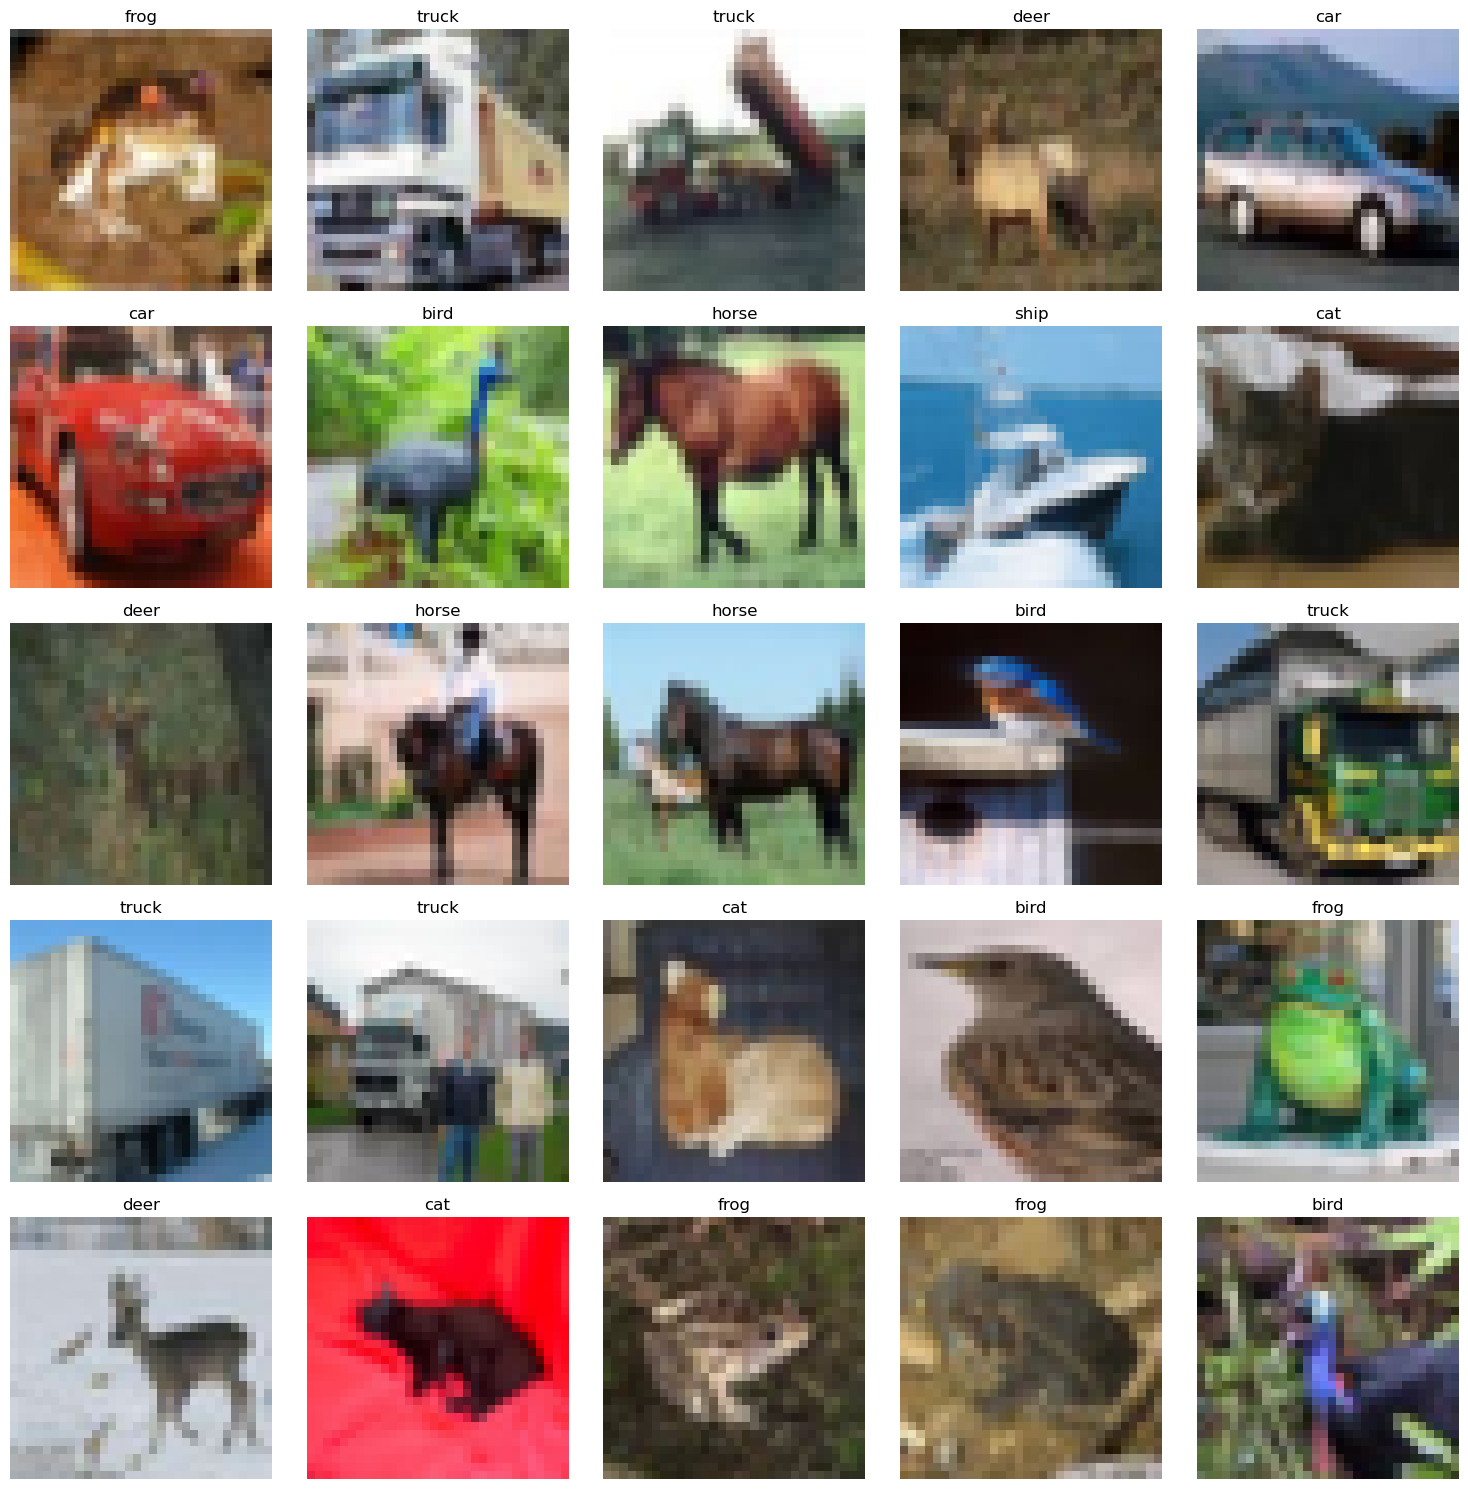

In [56]:
import matplotlib.pyplot as plt

x_train = train_dataset.dataset.data
y_train = train_dataset.dataset.targets

# plt.imshow(x_train[0])
# plt.axis("off")
# plt.show()

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(x_train[idx])
        axes[i, j].axis("off")
        axes[i, j].set_title(classes[y_train[idx]])

plt.tight_layout()
plt.show()

#### 학습
1. Data 다운 & 저장 → Storage
2. 전처리 → CPU
    - 데이터 표준화
        - Tensor 자료형 변형
        - X - Y 관계 지정
        - 데이터 동일 양식
    - Batch 구성
3. 학습 → GPU
    - 순전파
    - 손실계산
    - 역전파

GPU의 학습 효율을 최대화하려면 필요한 데이터를 빠르게 찾아야 하고<br/>
한 번에 얼만큼 불러와 어떤 처리를 할지 등등을 먼저 지정해줘야 한다.<br/>
아래는 DataLoader가 효율적으로 데이터를 불러올 수 있도록 커스덤 데이터셋을 만드는 과정이다.

## 7. 커스텀 데이터셋 클래스 예시

커스텀 데이터셋을 만드는 방법을 알아봅니다.


In [57]:
class CustomCIFAR10(Dataset):
    """
    커스텀 데이터셋 클래스 예시
    실제로는 위의 torchvision.datasets.CIFAR10을 사용하지만,
    커스텀 데이터셋을 만드는 방법을 보여주기 위한 예시입니다.
    """
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform # 이미지 변환 기법 방식
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [58]:
train_dataset.__len__()

40000

In [59]:
x, y = train_dataset.__getitem__(0)
print(x, y)

tensor([[[1.6999, 1.6612, 1.6805,  ..., 1.5255, 1.5255, 1.5061],
         [1.6418, 1.6030, 1.6224,  ..., 1.4479, 1.4479, 1.4479],
         [1.6418, 1.6030, 1.6224,  ..., 1.4285, 1.4285, 1.4673],
         ...,
         [1.7581, 1.6805, 1.6805,  ..., 1.7581, 1.7193, 1.6999],
         [1.7581, 1.6805, 1.6805,  ..., 1.7581, 1.7193, 1.7193],
         [1.7775, 1.6999, 1.6805,  ..., 1.7968, 1.7775, 1.7387]],

        [[2.1838, 2.1445, 2.1445,  ..., 2.0461, 2.0461, 2.0265],
         [2.0855, 2.0658, 2.0855,  ..., 1.9675, 1.9675, 1.9675],
         [2.0855, 2.0658, 2.0855,  ..., 1.9478, 1.9478, 1.9871],
         ...,
         [2.1641, 2.0658, 2.0658,  ..., 2.1051, 2.0658, 2.0461],
         [2.1641, 2.0658, 2.0658,  ..., 2.1051, 2.0658, 2.0461],
         [2.1641, 2.0855, 2.0855,  ..., 2.0855, 2.0658, 2.0068]],

        [[2.7537, 2.7537, 2.7537,  ..., 2.7537, 2.7537, 2.7537],
         [2.7537, 2.7147, 2.7342,  ..., 2.7342, 2.7342, 2.7342],
         [2.7537, 2.7342, 2.7342,  ..., 2.7342, 2.7342, 2.

In [60]:
print(x.shape)

torch.Size([3, 32, 32])


## 8. DataLoader

데이터를 배치 단위로 로드하는 DataLoader를 설정합니다.


In [61]:
batch_size = 32 # 128

train_loader = DataLoader(
    train_dataset,          # 어디에서 데이터를 가져와 어떻게 처리할 것인지
    batch_size=batch_size,  # 한 배치를 몇 개 데이터로 구성할 것인지
    shuffle=True,           # 섞을지 말지
    num_workers=2           # CPU에서 수행하는 작업이므로, CPU core를 얼마나 할당할지
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

print(f"Train batches: {len(train_loader)}") # Batch들의 수
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")



Train batches: 1250
Validation batches: 313
Test batches: 313


In [62]:
test_dataset.__len__() / batch_size

312.5

In [63]:
x = iter(range(10)) # 이터레이터로 변환 → next() 사용 가능

In [64]:
# 반복 실행마다 다음 요소 출력
next(x)

0

In [65]:
# 첫 번째 배치만 꺼내 살펴보기
for x, y in train_loader:
    print(x.shape, y.shape)
    break

# torch.Size([batch, channel, height, width]) torch.Size([정답(y) 수])

torch.Size([32, 3, 32, 32]) torch.Size([32])


In [66]:
# 샘플 배치 확인
sample_batch = next(iter(train_loader)) # 이터레이션 처리
sample_images, sample_labels = sample_batch
print(f"\nSample batch - Images shape: {sample_images.shape}")
print(f"Sample batch - Labels shape: {sample_labels.shape}")


Sample batch - Images shape: torch.Size([32, 3, 32, 32])
Sample batch - Labels shape: torch.Size([32])


## 9. 학습 및 평가 함수

모델 학습과 평가를 위한 함수들을 정의합니다.


In [67]:
#tqdm → 진행도바 그려주는 라이브러리
import time

for i in tqdm(range(100)):
    time.sleep(0.1)

100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


In [68]:
def train_epoch(model, loader, criterion, optimizer, device):
    """한 에포크 학습"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        # 각 이미지/라벨 배치를 GPU가 있을 경우 GPU로 이동
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass: 순전파
        optimizer.zero_grad()
        outputs = model(images) # 예측값

        # 손실 계산
        loss = criterion(outputs, labels) # 손실함수(예측값, 정답)
        
        # Backward pass: 역전파
        loss.backward()
        optimizer.step()
        
        # 통계
        running_loss += loss.item() # 손실 총합 = 에포크 손실
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item() # 맞춘 횟수 → 정확도 계산에 사용
        
        # 프로그레스 바 업데이트
        pbar.set_postfix({
            'loss': f'{running_loss / (pbar.n + 1):.4f}',
            'acc': f'{100. * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [69]:
def validate_epoch(model, loader, criterion, device):
    """한 에포크 검증"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    # Gradient 계산을 하지 않으면서 처리 → GPU 메모리 낭비 방지
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels) # 손실 계산
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{running_loss / (pbar.n + 1):.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


In [70]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, best_model_path='best_model.pth'):

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf') # 무한
    best_model_wts = None
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # 학습 1250 번
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 검증 313번
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # 히스토리 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # best val_loss 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, best_model_path)
            print(f'>> Best model saved! val_loss: {val_loss:.4f}')
        
        # 결과 출력
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
    return history

print("전체 학습 루프 함수 정의 완료")


전체 학습 루프 함수 정의 완료


## 11. 모델 학습 실행

CNN 모델을 학습시킵니다.


In [71]:
# 모델 초기화
model = CNNModel(num_classes=len(classes)).to(device) # .to(device)로 모델 위치 일치시키기

# Optimizer와 Loss
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()


# 학습 실행
num_epochs = 20
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    best_model_path='best_model.pth'
)



Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:07<00:00, 41.95it/s, loss=1.3108, acc=51.63%]


>> Best model saved! val_loss: 1.3024
Train Loss: 1.5680, Train Acc: 42.74%
Val Loss: 1.3024, Val Acc: 51.63%

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.76it/s, loss=1.1794, acc=58.29%]


>> Best model saved! val_loss: 1.1681
Train Loss: 1.3134, Train Acc: 53.19%
Val Loss: 1.1681, Val Acc: 58.29%

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.08it/s, loss=1.1604, acc=58.64%]


>> Best model saved! val_loss: 1.1456
Train Loss: 1.2171, Train Acc: 56.61%
Val Loss: 1.1456, Val Acc: 58.64%

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.20it/s, loss=1.1412, acc=60.24%]


>> Best model saved! val_loss: 1.1267
Train Loss: 1.1743, Train Acc: 58.82%
Val Loss: 1.1267, Val Acc: 60.24%

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 52.08it/s, loss=1.1299, acc=60.21%]


>> Best model saved! val_loss: 1.1118
Train Loss: 1.1353, Train Acc: 60.06%
Val Loss: 1.1118, Val Acc: 60.21%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 53.78it/s, loss=1.1009, acc=61.63%]


>> Best model saved! val_loss: 1.0939
Train Loss: 1.0993, Train Acc: 61.45%
Val Loss: 1.0939, Val Acc: 61.63%

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.24it/s, loss=1.0977, acc=61.16%]


Train Loss: 1.0756, Train Acc: 62.72%
Val Loss: 1.0942, Val Acc: 61.16%

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.79it/s, loss=0.9910, acc=65.63%]


>> Best model saved! val_loss: 0.9910
Train Loss: 1.0575, Train Acc: 63.05%
Val Loss: 0.9910, Val Acc: 65.63%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 53.38it/s, loss=1.0435, acc=63.98%]


Train Loss: 1.0404, Train Acc: 63.76%
Val Loss: 1.0369, Val Acc: 63.98%

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 52.24it/s, loss=1.0456, acc=64.36%]


Train Loss: 1.0314, Train Acc: 64.09%
Val Loss: 1.0423, Val Acc: 64.36%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 54.34it/s, loss=1.0492, acc=64.00%]


Train Loss: 1.0133, Train Acc: 64.94%
Val Loss: 1.0425, Val Acc: 64.00%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 49.91it/s, loss=1.0603, acc=64.74%]


Train Loss: 0.9857, Train Acc: 65.58%
Val Loss: 1.0434, Val Acc: 64.74%

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 48.80it/s, loss=1.0835, acc=63.74%]


Train Loss: 0.9859, Train Acc: 66.01%
Val Loss: 1.0696, Val Acc: 63.74%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 50.37it/s, loss=1.1720, acc=62.15%]


Train Loss: 0.9638, Train Acc: 66.42%
Val Loss: 1.1570, Val Acc: 62.15%

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 46.60it/s, loss=1.1096, acc=64.04%]


Train Loss: 0.9654, Train Acc: 66.65%
Val Loss: 1.0954, Val Acc: 64.04%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 55.08it/s, loss=1.0367, acc=64.87%]


Train Loss: 0.9669, Train Acc: 66.59%
Val Loss: 1.0367, Val Acc: 64.87%

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 55.98it/s, loss=1.0514, acc=64.92%]


Train Loss: 0.9493, Train Acc: 67.05%
Val Loss: 1.0514, Val Acc: 64.92%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 55.71it/s, loss=1.0403, acc=66.03%]


Train Loss: 0.9416, Train Acc: 67.25%
Val Loss: 1.0370, Val Acc: 66.03%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:05<00:00, 53.35it/s, loss=1.0697, acc=65.10%]


Train Loss: 0.9254, Train Acc: 67.71%
Val Loss: 1.0697, Val Acc: 65.10%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 313/313 [00:06<00:00, 51.80it/s, loss=1.0471, acc=66.32%]

Train Loss: 0.9316, Train Acc: 67.88%
Val Loss: 1.0371, Val Acc: 66.32%


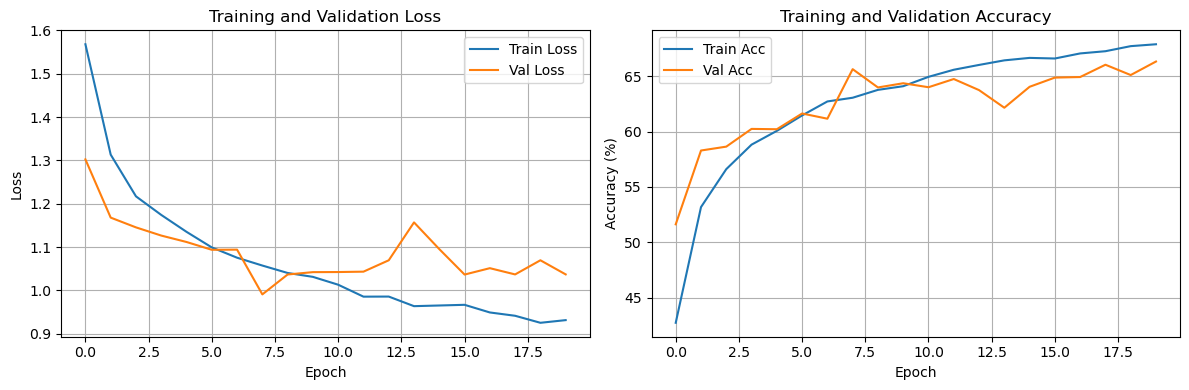

Training history saved to 'training_history.png'


In [72]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print("Training history saved to 'training_history.png'")


## 12. 테스트

학습된 모델을 테스트 데이터로 평가합니다.


In [73]:
# best model을 불러오는 코드
best_model = torch.load('best_model.pth', map_location=device)
model.load_state_dict(best_model)
print("Best model loaded from 'best_model.pth'")


Best model loaded from 'best_model.pth'


In [74]:
def test_model(model, test_loader, device):
    """테스트 데이터로 모델 평가"""
    model.eval()
    correct = 0
    total = 0
    
    # 클래스별 정확도 계산을 위한 변수
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 클래스별 정확도
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # 전체 정확도
    accuracy = 100. * correct / total
    print(f'\nTest Accuracy: {accuracy:.2f}%')
    
    # 클래스별 정확도
    print('\nClass-wise Accuracy:')
    for i in range(10):
        class_acc = 100 * class_correct[i] / class_total[i]
        print(f'{classes[i]:>10s}: {class_acc:.2f}%')
    
    return accuracy

test_accuracy = test_model(model, test_loader, device)


Testing: 100%|██████████| 313/313 [00:05<00:00, 61.18it/s]


Test Accuracy: 65.98%

Class-wise Accuracy:
     plane: 69.20%
       car: 78.50%
      bird: 46.60%
       cat: 45.20%
      deer: 59.70%
       dog: 58.20%
      frog: 79.50%
     horse: 64.10%
      ship: 77.30%
     truck: 81.50%


## 13. Pretrained 모델 불러오기

사전 훈련된 모델을 불러오는 방법을 알아봅니다.


In [75]:
# torchvision에서 모델 불러오기
print("[torchvision models]")
resnet18 = models.resnet18(pretrained=True)
print(f"ResNet18 loaded: {type(resnet18)}")


C:\Users\elian\miniconda3\envs\pytorch_tutorial\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\elian\miniconda3\envs\pytorch_tutorial\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[torchvision models]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\elian/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 59.1MB/s]


ResNet18 loaded: <class 'torchvision.models.resnet.ResNet'>


In [76]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [77]:
# 마지막 레이어 수정 (CIFAR-10은 10개 클래스)
num_features = resnet18.fc.in_features # 512라는 숫자를 가져오는 방법 (fc): Linear(in_features=512, out_features=1000, bias=True)
resnet18.fc = nn.Linear(in_features=num_features, out_features=len(classes)) # in 512 out 10
print(f"Modified final layer for 10 classes")

Modified final layer for 10 classes


In [78]:
# timm에서 모델 불러오기
print("\n[timm models]")
efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=10)
print(f"EfficientNet-B0 loaded: {type(efficientnet)}")


[timm models]
EfficientNet-B0 loaded: <class 'timm.models.efficientnet.EfficientNet'>


In [79]:
# timm에서 사용 가능한 모델 확인 (처음 10개만)
available_models = timm.list_models(pretrained=True)[:10]
print(f"\nAvailable pretrained models (first 10): {available_models}")



Available pretrained models (first 10): ['aimv2_1b_patch14_224.apple_pt', 'aimv2_1b_patch14_336.apple_pt', 'aimv2_1b_patch14_448.apple_pt', 'aimv2_3b_patch14_224.apple_pt', 'aimv2_3b_patch14_336.apple_pt', 'aimv2_3b_patch14_448.apple_pt', 'aimv2_huge_patch14_224.apple_pt', 'aimv2_huge_patch14_336.apple_pt', 'aimv2_huge_patch14_448.apple_pt', 'aimv2_large_patch14_224.apple_pt']


## 14. 전이학습 (Transfer Learning)

사전 훈련된 모델을 활용한 전이학습 방법을 알아봅니다.


In [80]:
# ResNet18로 전이학습 예시
model_transfer = models.resnet18(pretrained=True)

In [81]:
# 방법 1: 모든 레이어 동결 (Feature Extractor로 사용)
print("[방법 1] Feature Extractor - 모든 레이어 동결")
for param in model_transfer.parameters():
    param.requires_grad = False # 기존 모델의 파라미터 동결 → 전이학습 과정에서 모델의 기존 학습된 파라미터가 영향받지 않도록 조치

# 마지막 레이어만 학습 가능하게 설정
num_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_features, 10) # requires_grad = True → 새로 붙였기 때문

# 학습 가능한 파라미터만 optimizer에 전달
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

trainable_params_1 = sum(p.numel() for p in model_transfer.parameters() if p.requires_grad)
print(f"학습 가능한 파라미터 수: {trainable_params_1:,}")

[방법 1] Feature Extractor - 모든 레이어 동결
학습 가능한 파라미터 수: 5,130


In [82]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
# 방법 2: 일부 레이어만 학습 (Fine-tuning)
print("\n[방법 2] Fine-tuning - 마지막 몇 개 레이어만 학습")
model_transfer2 = models.resnet18(pretrained=True)

# 처음 레이어들은 동결
for name, param in model_transfer2.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

# 마지막 레이어 수정
model_transfer2.fc = nn.Linear(in_features=model_transfer2.fc.in_features, out_features=len(classes))

# 학습 가능한 파라미터만 optimizer에 전달
optimizer_transfer2 = optim.Adam(
    filter(lambda p: p.requires_grad, model_transfer2.parameters()), 
    lr=0.001
)

trainable_params_2 = sum(p.numel() for p in model_transfer2.parameters() if p.requires_grad)
print(f"학습 가능한 파라미터 수: {trainable_params_2:,}")


[방법 2] Fine-tuning - 마지막 몇 개 레이어만 학습
학습 가능한 파라미터 수: 8,398,858


In [84]:
# 방법 3: 전체 모델 Fine-tuning (작은 learning rate 사용)
print("\n[방법 3] Full Fine-tuning - 전체 모델 학습 (작은 LR)")
model_transfer3 = models.resnet18(pretrained=True)
model_transfer3.fc = nn.Linear(model_transfer3.fc.in_features, 10)

# Differential learning rate: Backbone은 작은 LR, 새 레이어는 큰 LR
optimizer_transfer3 = optim.Adam([
    {'params': model_transfer3.layer4.parameters(), 'lr': 1e-4},
    {'params': model_transfer3.fc.parameters(), 'lr': 1e-3}
])

print(f"Backbone LR: 1e-4, New layer LR: 1e-3")



[방법 3] Full Fine-tuning - 전체 모델 학습 (작은 LR)
Backbone LR: 1e-4, New layer LR: 1e-3


In [85]:
# 전이학습 모델로 간단히 학습 (3 에포크만)
print("\n전이학습 모델 학습 시작 (3 epochs)...")
model_transfer = model_transfer.to(device)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    print(f'\nEpoch {epoch+1}/3')
    train_loss, train_acc = train_epoch(
        model_transfer, train_loader, criterion, optimizer_transfer, device
    )
    val_loss, val_acc = validate_epoch(
        model_transfer, val_loader, criterion, device
    )
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')



전이학습 모델 학습 시작 (3 epochs)...

Epoch 1/3


Validation: 100%|██████████| 313/313 [00:13<00:00, 23.91it/s, loss=1.6716, acc=42.18%]


Train Loss: 1.7592, Train Acc: 38.04%
Val Loss: 1.6716, Val Acc: 42.18%

Epoch 2/3


Validation: 100%|██████████| 313/313 [00:12<00:00, 24.35it/s, loss=1.6081, acc=44.96%]


Train Loss: 1.6433, Train Acc: 42.84%
Val Loss: 1.6081, Val Acc: 44.96%

Epoch 3/3


Validation: 100%|██████████| 313/313 [00:13<00:00, 23.56it/s, loss=1.6299, acc=44.60%]

Train Loss: 1.6350, Train Acc: 42.80%
Val Loss: 1.6195, Val Acc: 44.60%


## 15. 모델 저장 및 불러오기

학습된 모델을 저장하고 불러오는 방법을 알아봅니다.


In [86]:
# 모델 저장
torch.save(model.state_dict(), 'cifar10_cnn_model.pth')
print("모델 가중치 저장 완료: cifar10_cnn_model.pth")

# 전체 모델 저장 (권장하지 않음, 하지만 가능함)
torch.save(model, 'cifar10_cnn_full_model.pth')
print("전체 모델 저장 완료: cifar10_cnn_full_model.pth")

# 모델 불러오기
loaded_model = CNNModel(num_classes=10)
loaded_model.load_state_dict(torch.load('cifar10_cnn_model.pth'))
loaded_model = loaded_model.to(device)
loaded_model.eval()
print("\n모델 가중치 불러오기 완료")

# 체크포인트 저장 (optimizer 상태 포함)
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}
torch.save(checkpoint, 'checkpoint.pth')
print("체크포인트 저장 완료: checkpoint.pth")


모델 가중치 저장 완료: cifar10_cnn_model.pth
전체 모델 저장 완료: cifar10_cnn_full_model.pth

모델 가중치 불러오기 완료
체크포인트 저장 완료: checkpoint.pth


## 16. 추론 예시

학습된 모델을 사용하여 새로운 이미지에 대한 예측을 수행합니다.


In [87]:
# 테스트 이미지 하나 가져오기
sample_image, sample_label = test_dataset[0]
sample_image_batch = sample_image.unsqueeze(0).to(device)  # 배치 차원 추가

# 추론
model.eval()
with torch.no_grad():
    output = model(sample_image_batch)
    probabilities = F.softmax(output, dim=1)
    predicted_class = output.argmax(dim=1).item()
    confidence = probabilities[0][predicted_class].item()

print(f"실제 클래스: {classes[sample_label]}")
print(f"예측 클래스: {classes[predicted_class]}")
print(f"신뢰도: {confidence * 100:.2f}%")

# Top-5 예측
top5_prob, top5_classes = torch.topk(probabilities, 5)
print("\nTop-5 예측:")
for i in range(5):
    print(f"{i+1}. {classes[top5_classes[0][i]]}: {top5_prob[0][i].item() * 100:.2f}%")


실제 클래스: cat
예측 클래스: cat
신뢰도: 30.59%

Top-5 예측:
1. cat: 30.59%
2. dog: 24.48%
3. horse: 13.28%
4. bird: 9.02%
5. deer: 5.46%
